In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pmdarima.arima import ndiffs
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [25]:
pv_data = pd.read_csv("pv_20220215.csv")
pv_data

,area,time,familyID,state,pvVoltage,pvCurrent,pvPower,gridVoltage,gridCurrent,gridPower,...,gridCurrentC,gridPowerC,accurgenamount,totalaccurgenamount,powerFactor,powerHz,errorState,outsidetemp,moduletemp,cdate
0,sc_jong,2022-01-01 00:00:00,Group010,N,0.0,0.0,0,230.53,0.40,0,...,0.40,0,0,46034400,0.007,60.0,0,0,0,2022-01-01 00:00:00
1,sc_jong,2022-01-01 00:00:00,Group011,5120,0.0,0.0,0,0.00,0.00,0,...,0.00,0,121800,23327000,0.000,0.0,0,0,0,2022-01-01 00:00:00
2,sc_jong,2022-01-01 00:00:00,Group012,5120,0.0,0.0,0,0.00,0.00,0,...,0.00,0,89700,21520000,0.000,0.0,0,0,0,2022-01-01 00:00:00
3,sc_jong,2022-01-01 00:00:00,Group020,N,0.0,0.0,0,230.31,0.28,0,...,0.31,0,0,14966280,0.028,59.9,0,0,0,2022-01-01 00:00:00
4,sc_jong,2022-01-01 00:00:00,Group021,5120,0.0,0.0,0,0.00,0.00,0,...,0.00,0,74900,14539000,0.000,0.0,0,0,0,2022-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244652,sc_jong,2022-02-01 14:30:00,Group010,N,0.0,0.0,0,231.62,48.40,33760,...,48.40,0,0,52088400,0.998,60.0,0,0,0,2022-02-01 14:29:59
244653,sc_jong,2022-02-01 14:30:00,Group011,0,553.7,30.6,16839,230.40,24.30,16586,...,24.30,0,104400,26524000,0.999,59.9,0,0,0,2022-02-01 14:29:59
244654,sc_jong,2022-02-01 14:30:00,Group012,0,545.9,30.3,16517,231.20,23.70,16177,...,23.70,0,92200,24151000,0.999,59.9,0,0,0,2022-02-01 14:29:59
244655,sc_jong,2022-02-01 14:30:00,Group020,N,0.0,0.0,0,231.51,16.15,11231,...,16.12,0,0,16967750,0.998,60.0,0,0,0,2022-02-01 14:29:59


In [26]:
pv_data['familyID'] = pv_data['familyID'].str.replace('-1','')

In [27]:
groups = pv_data.groupby(pv_data.familyID)
groups.first().index[:]

Index(['13', '14', '16', '17', '20', '21', '22', '32', '34', '37', '40', '41',
       '6', 'Group010', 'Group011', 'Group012', 'Group020', 'Group021'],
      dtype='object', name='familyID')

In [28]:
for i in groups.first().index[:]:
    globals()['pv_df_'+str(i)] = groups.get_group(str(i))
    print('pv_df_'+str(i))

pv_df_13
pv_df_14
pv_df_16
pv_df_17
pv_df_20
pv_df_21
pv_df_22
pv_df_32
pv_df_34
pv_df_37
pv_df_40
pv_df_41
pv_df_6
pv_df_Group010
pv_df_Group011
pv_df_Group012
pv_df_Group020
pv_df_Group021


In [29]:
timeSeries = pv_df_21.loc[:,["time","pvPower","familyID"]]
timeSeries.index = pd.to_datetime(timeSeries.time)
ts = timeSeries.drop("time", axis=1)
df_summary_14 = pd.DataFrame()
df_summary_14['pvPower'] = ts.pvPower.resample('1H').sum()
df_summary_14

,pvPower
time,
2022-01-01 07:00:00,1891
2022-01-01 08:00:00,58969
2022-01-01 09:00:00,106008
2022-01-01 10:00:00,104761
2022-01-01 11:00:00,121112
...,...
2022-02-01 10:00:00,143033
2022-02-01 11:00:00,150128
2022-02-01 12:00:00,150488


In [30]:
weather = pd.read_csv("weather.csv", encoding='cp949')

In [31]:
data_list = []
for i in range(1,len(weather.columns)):
    if(weather.isnull().sum()[i] == 758):
        data_list.append(weather.columns[i])

weather.drop(data_list, axis=1,inplace=True)
weather.drop(['지점','지점명'], axis=1,inplace=True)
weather.rename(columns={'기온(°C)':'Temperature','강수량(mm)':'precipitation','습도(%)':'humidity','일조(hr)':'sunshine','지면온도(°C)':'ground_temp'}, inplace=True)
weather.rename(columns={'일시':'time'}, inplace=True)
weather.index = pd.to_datetime(weather.time)
weather.drop(['time'], axis=1, inplace=True)

#기상청 데이터 병합
df_sum = pd.merge(df_summary_14, weather, left_index= True, right_index=True, how='left');
df_sum.fillna(0);

In [32]:
train_df, test_df = df_summary_14[:int(len(df_summary_14) * 0.75)], df_summary_14[int(len(df_summary_14) * 0.75):]

In [33]:
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

In [34]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [35]:
n_past = 48
n_future = 24
n_features = 1

In [36]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [37]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, activation = 'tanh',return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, activation = 'tanh',return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 1)]      0           []                               
                                                                                                  
 lstm_6 (LSTM)                  [(None, 100),        40800       ['input_3[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector_2 (RepeatVector)  (None, 24, 100)     0           ['lstm_6[0][0]']                 
                                                                                            

In [38]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,activation = 'tanh',return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, activation = 'tanh',return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, activation = 'tanh',return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, activation = 'tanh',return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 48, 1)]      0           []                               
                                                                                                  
 lstm_8 (LSTM)                  [(None, 48, 100),    40800       ['input_4[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_9 (LSTM)                  [(None, 100),        80400       ['lstm_8[0][0]']                 
                                 (None, 100),                                               

In [39]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.RMSprop(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])
model_e2d2.compile(optimizer=tf.keras.optimizers.RMSprop(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

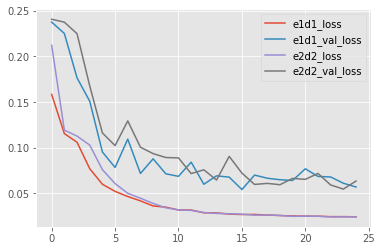

In [40]:
plt.plot(history_e1d1.history['loss'], label="e1d1_loss")
plt.plot(history_e1d1.history['val_loss'], label="e1d1_val_loss")
plt.plot(history_e2d2.history['loss'], label="e2d2_loss")
plt.plot(history_e2d2.history['val_loss'], label="e2d2_val_loss")
plt.legend()

In [41]:
pred_e1d1=model_e1d1.predict(X_test)
pred_e2d2=model_e2d2.predict(X_test)

In [42]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    #pred1_e1d1[:,:,index]=scaler.inverse_transform(pred1_e1d1[:,:,index])
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    #pred1_e2d2[:,:,index]=scaler.inverse_transform(pred1_e2d2[:,:,index])
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [44]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
for index,i in enumerate(train_df.columns):
  print(i)
  for j in range(1,25):
    print("Hour ",j,":")
    print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred_e1d1[:,j-1,index]),end=", ")
    print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred_e2d2[:,j-1,index]))
    print("RRMSE-E1D1 : ",mean_squared_error(y_test[:,j-1,index],pred_e1d1[:,j-1,index], squared=False) / np.mean(y_test),end=", ")
    print("RRMSE-E2D2 : ",mean_squared_error(y_test[:,j-1,index],pred_e2d2[:,j-1,index], squared=False) / np.mean(y_test))
    print("R2-E1D1 : ", r2_score(y_test[:,j-1,index],pred_e1d1[:,j-1,index]) )
    print("R2-E2D2 : ", r2_score(y_test[:,j-1,index],pred_e2d2[:,j-1,index]) )
  print()
  print()

pvPower
Hour  1 :
MAE-E1D1 :  17131.604198227582, MAE-E2D2 :  15324.450008555355
RRMSE-E1D1 :  0.7014683091167636, RRMSE-E2D2 :  0.6837940217330446
R2-E1D1 :  0.7821412810040954
R2-E2D2 :  0.7929813681132569
Hour  2 :
MAE-E1D1 :  16068.062219636053, MAE-E2D2 :  15379.628195167606
RRMSE-E1D1 :  0.6764358499684142, RRMSE-E2D2 :  0.6776896188493817
R2-E1D1 :  0.7970903360499888
R2-E2D2 :  0.7963374558226182
Hour  3 :
MAE-E1D1 :  15716.46358933408, MAE-E2D2 :  15419.985983237242
RRMSE-E1D1 :  0.6783403407835675, RRMSE-E2D2 :  0.6744330266698682
R2-E1D1 :  0.795853085933504
R2-E2D2 :  0.7981981294138838
Hour  4 :
MAE-E1D1 :  15836.108759431758, MAE-E2D2 :  15450.93333338876
RRMSE-E1D1 :  0.6898445075202398, RRMSE-E2D2 :  0.6742051296811044
R2-E1D1 :  0.7888699986074952
R2-E2D2 :  0.7983344877077134
Hour  5 :
MAE-E1D1 :  16417.64714687706, MAE-E2D2 :  15542.864857209035
RRMSE-E1D1 :  0.7016699595070942, RRMSE-E2D2 :  0.6801816270935065
R2-E1D1 :  0.7815694919067484
R2-E2D2 :  0.7947433094477

In [45]:
df_1 = pd.DataFrame(pred_e1d1[:,:,0])
df_2 = pd.DataFrame(pred_e2d2[:,:,0])

In [46]:
df_test = pd.DataFrame(y_test[:,:,0])

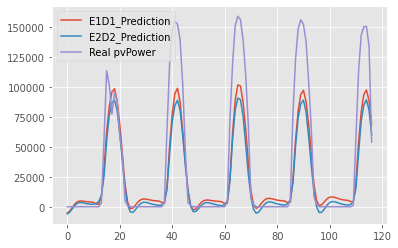

In [47]:
plt.plot(df_1[23], label="E1D1_Prediction")
plt.plot(df_2[23], label="E2D2_Prediction")
plt.plot(df_test[23], label="Real pvPower")
plt.legend()